Restarted GenAMM (Python 3.11.4)

In [2]:
import pickle
import qGaussian
import qPowerLaw
import qlogNormal
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
from scipy.stats import kstest
import matplotlib.pyplot as plt
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/usdc_weth_005.pickle'
with open(dataset_path, 'rb') as f:
    df = pickle.load(f)
df.index = pd.to_datetime(df.index)

df = df[ (df.index >= datetime(2023, 1, 1, 0, 0, 0)) & (df.index < datetime(2024, 1, 1, 0, 0, 0)) ]
df_swap = df[ (df.Event=='Swap_X2Y') | (df.Event=='Swap_Y2X') ]
df_mint = df[ df.Event=='Mint' ]
df_burn_mint = df[ (df.Event=='Burn') | (df.Event=='Mint') ]
df_burn = df[ df.Event=='Burn' ]

'''
df_burn_mint_full = df_burn_mint.copy()
df_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]
df_swap_full = df_swap.copy()
df_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]
'''

"\ndf_burn_mint_full = df_burn_mint.copy()\ndf_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]\ndf_swap_full = df_swap.copy()\ndf_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]\n"

There are 34.374830190729774 % values with tick_start in range=]tick_lower, tick_upper[
There are 40.422757159158834 % values with tick_start <= tick_lower
There are 25.202412650111395 % values with tick_start >= tick_upper


  0%|          | 0/18403 [00:00<?, ?it/s]

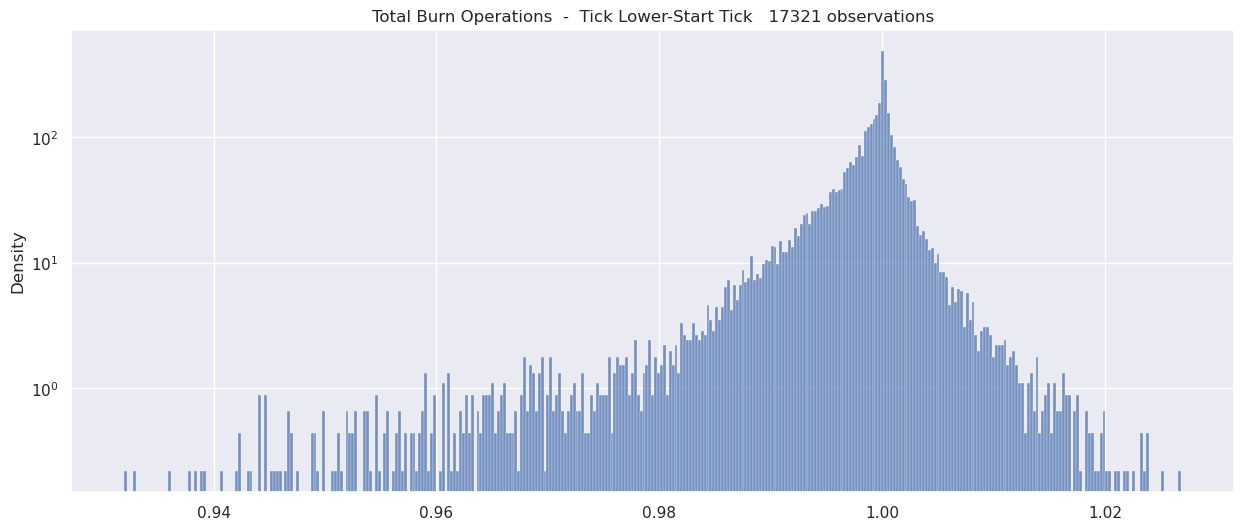

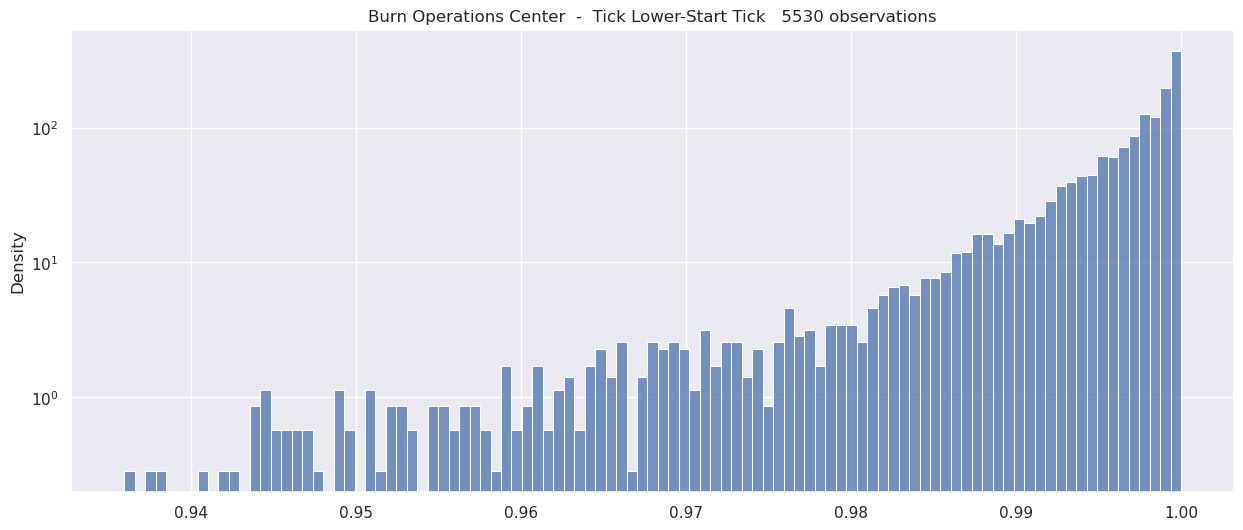

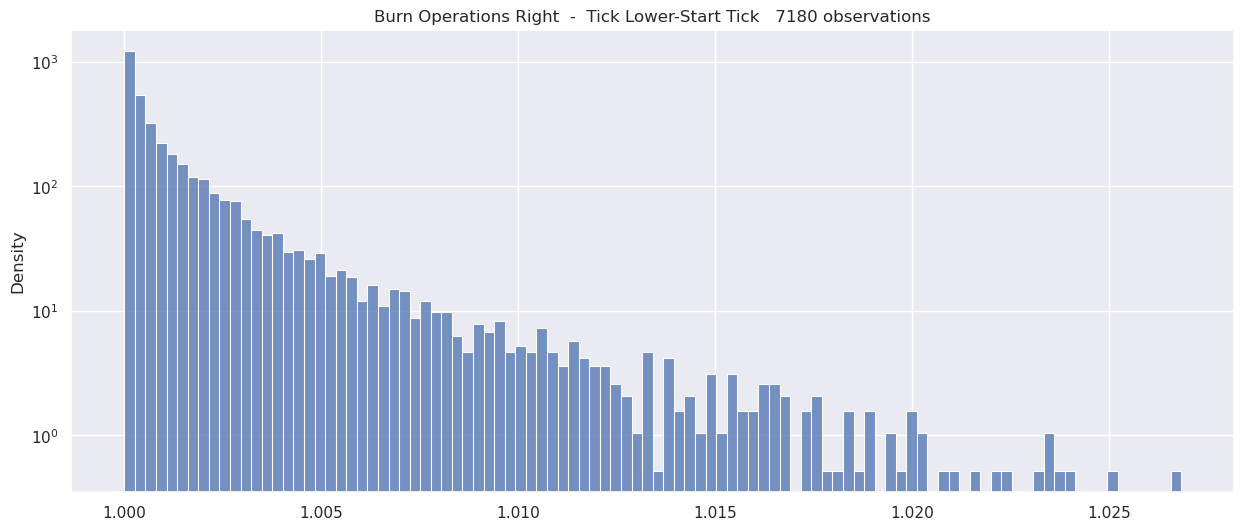

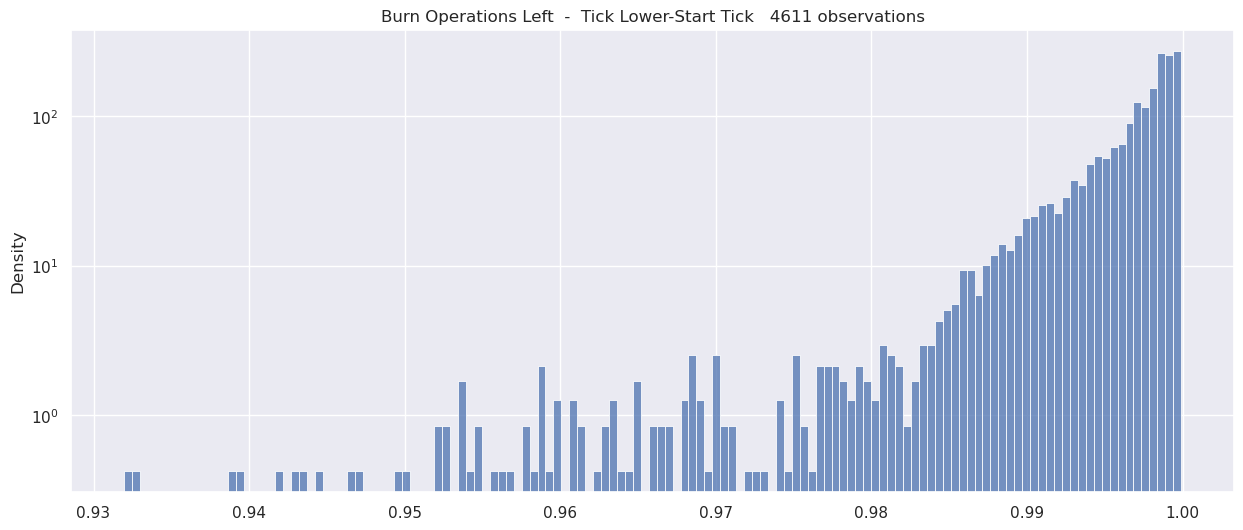

In [3]:
#----------------------------------- Compute the price ranges
with open('../data/df_burn_clean.pickle', 'rb') as f:
    df_burn_clean = pickle.load(f)

df_burn_clean[[
    'tick_lower', 'tick_upper', 'block_number', 'tick'
    ]] =df_burn_clean[[
        'tick_lower', 'tick_upper', 'block_number', 'tick']].astype(int)

print('There are', 100*len(df_burn_clean[(df_burn_clean.tick > df_burn_clean.tick_lower) &\
    (df_burn_clean.tick < df_burn_clean.tick_upper)]) / len(df_burn_clean),
    '% values with tick_start in range=]tick_lower, tick_upper[')
print('There are', 100*len(df_burn_clean[
    df_burn_clean.tick <= df_burn_clean.tick_lower]) / len(df_burn_clean),
    '% values with tick_start <= tick_lower')
print('There are', 100*len(df_burn_clean[
    df_burn_clean.tick >= df_burn_clean.tick_upper]) / len(df_burn_clean),
    '% values with tick_start >= tick_upper')

up_bound = np.log(10**9) / np.log(1.0001)
low_bound = np.log(10**9/6) / np.log(1.0001)
tick_diff, flag = list(), list()
for burn_iloc in tqdm(range(len(df_burn_clean))): #Iterate over the mint events
    tu, tl, ts = df_burn_clean[['tick_upper', 'tick_lower', 'tick']].iloc[burn_iloc]
    if (tu <= up_bound) and (tl >= low_bound):
        tick_diff.append(tl / ts)
        if (ts > tl) and (ts < tu):
            flag.append('c')
        elif ts <= tl:
            flag.append('r')
        elif ts >= tu:
            flag.append('l')
tick_diff = np.array(tick_diff)
flag = np.array(flag)

x_train = tick_diff.copy() #np.ceil((df_burn_clean.tick_lower - df_burn_clean.tick) / 10)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set(yscale='log')
sns.histplot(x_train, stat='density')
plt.title('Total Burn Operations  -  Tick Lower-Start Tick   '+str(len(x_train))+' observations')
plt.show()

x_center = x_train[ flag=='c' ]
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set(yscale='log')
sns.histplot(x_center, stat='density')
plt.title('Burn Operations Center  -  Tick Lower-Start Tick   '+str(len(x_center))+' observations')
plt.show()

x_right = x_train[ flag=='r' ]
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set(yscale='log')
sns.histplot(x_right, stat='density', bins=100)
plt.title('Burn Operations Right  -  Tick Lower-Start Tick   '+str(len(x_right))+' observations')
plt.show()

x_left = x_train[ flag=='l' ]
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.set(yscale='log')
sns.histplot(x_left, stat='density')
plt.title('Burn Operations Left  -  Tick Lower-Start Tick   '+str(len(x_left))+' observations')
plt.show()

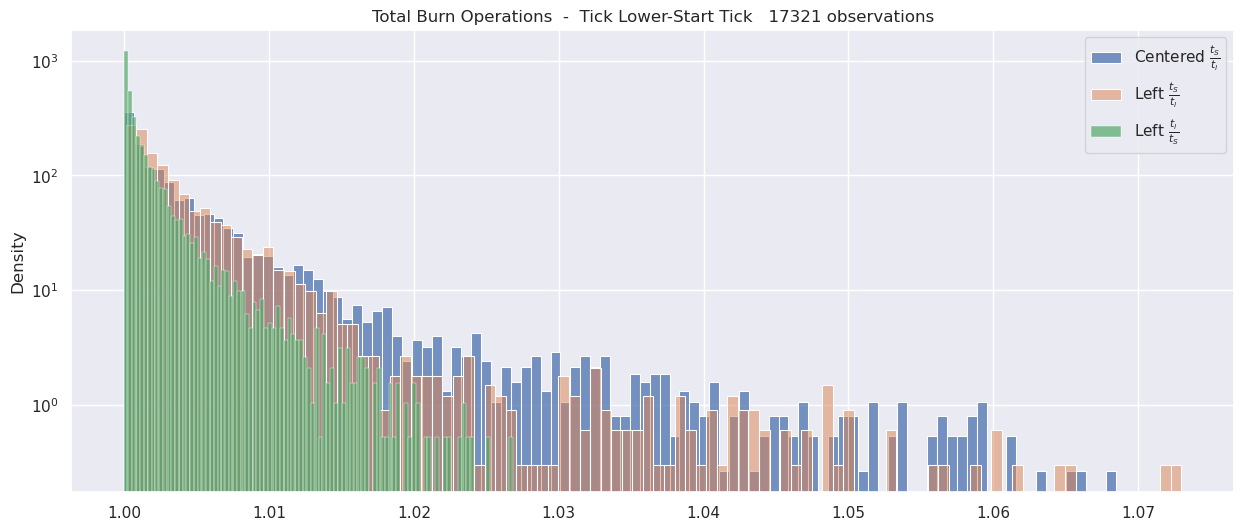

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
n_bins = 100

ax.set(yscale='log')
sns.histplot(1/x_center, stat='density', label=r'Centered $\frac{t_S}{t_l}$', bins=n_bins)
sns.histplot(1/x_left, stat='density', alpha=0.5, label=r'Left $\frac{t_S}{t_l}$', bins=n_bins)
sns.histplot(x_right, stat='density', alpha=0.7, label=r'Left $\frac{t_l}{t_S}$', bins=n_bins)
plt.title('Total Burn Operations  -  Tick Lower-Start Tick   '+str(len(x_train))+' observations')
plt.legend()
plt.show()

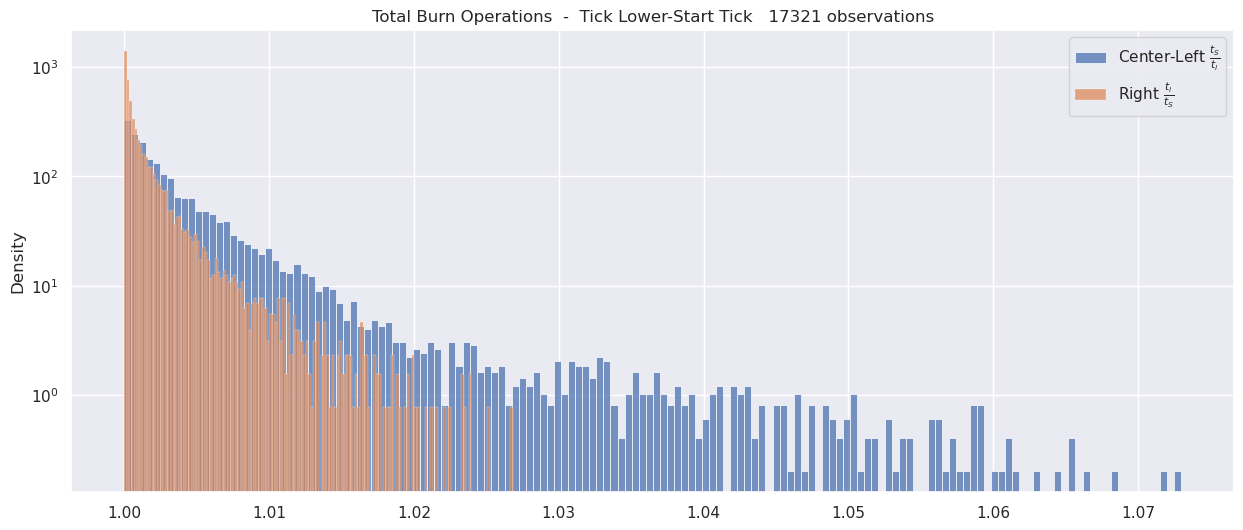

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
n_bins = 150

x_center_left = np.concatenate((x_center, x_left))

ax.set(yscale='log')
sns.histplot(1/x_center_left, stat='density', label=r'Center-Left $\frac{t_S}{t_l}$', bins=n_bins)
sns.histplot(x_right, stat='density', alpha=0.7, label=r'Right $\frac{t_l}{t_S}$', bins=n_bins)
plt.title('Total Burn Operations  -  Tick Lower-Start Tick   '+str(len(x_train))+' observations')
plt.legend()
plt.show()

In [21]:
from scipy.stats import halfcauchy, fatiguelife, genpareto, kappa3, pareto

def general_ll(x, pdf_func, pars):
    return np.sum(np.log(pdf_func(x, *pars)))

In [22]:
x_temp = 1/x_center_left

# Comparison of the log-likelihood
max_ll, best_dist = -np.inf, None
for dist, name in zip([halfcauchy, fatiguelife, genpareto, kappa3, pareto, qPowerLaw],
                      ['Half-Cauchy', 'Fatigue Life', 'Generalized Pareto', 'Kappa 3', 'Pareto', 'qPowerLaw']):
    try:
        if name != 'qPowerLaw':
            pars = dist.fit(x_temp)
            print(f"{name} - Parameters: {pars}")
            curr_ll = general_ll(x_temp, dist.pdf, pars)
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        else:
            pars = dist.general_fit(x_temp)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(x_temp, dist.pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

Half-Cauchy - Parameters: (1.0000048937412647, 0.03487219073933784)
Half-Cauchy - Log-Likelihood: 28945.387794801216

Fatigue Life - Parameters: (1.4926051445221584, 0.9998483994614102, 0.002409966773304784)
Fatigue Life - Log-Likelihood: 44403.97379997159

Generalized Pareto - Parameters: (-1.3421758092482337, 0.006427472870957772, 1.431507221940031)
Generalized Pareto - Log-Likelihood: 3512.4439578781657

Kappa 3 - Parameters: (6.649303411805484, 0.9992141516324899, 0.031023322256110764)
Kappa 3 - Log-Likelihood: 32054.365733072962

Pareto - Parameters: (2.2931346736563474, 0.9933123894230402, 0.0066925043814034515)
Pareto - Log-Likelihood: 44626.510715045006

qPowerLaw - Parameters: [0.4465813334894786, 1.0463456867060605, 0.99999993094643, -0.36077439639820147, 1.3607792153453913]
qPowerLaw - Log-Likelihood: 12839.8771382188

The best distribution is: Pareto, with a Log-Likelihood of 44626.510715045006


In [23]:
# Comparison test
class Fit_comparison_test():
    '''
    Fit comparison test for assessing the goodness of the Expected Shortfall estimate
    '''
    def __init__(self, one_side=True, n_boot=10_000):
        '''
        Args:
            one_side (bool): if True, the test is one sided (i.e. H0: mu >= mu_target). Default is False
            n_boot (int): the number of bootstrap replications. Default is 10_000
        '''
        self.mu_target = 0
        self.one_side = one_side
        self.n_boot = n_boot
    
    def null_statistic(self, B_data):
        '''
        Compute the null statistic for the bootstrap sample
        Args:
            B_data (numpy array): the bootstrap sample

        Returns:
            float: the null statistic
        '''
        return (np.mean(B_data) - self.obs_mean) * np.sqrt(self.n) / np.std(B_data)
    
    def statistic(self, data):
        '''
        Compute the test statistic for the original sample
        Args:
            data (numpy array): the original sample

        Returns:
            float: the test statistic
        '''
        return (self.obs_mean - self.mu_target) * np.sqrt(self.n) / np.std(data)
    
    def fit_transform(self, data, pdf1, pdf2):
        '''
        Transform the data to compute the Fit comparison test
        Args:
            Q_ (numpy array): the quantile estimates
            E_ (numpy array): the expected shortfall estimates
            Y_ (numpy array): the actual time series

        Returns:
            numpy array: the transformed data
        '''

        return np.log((pdf2(data))) - np.log(pdf1(data))

    def __call__(self, x, pdf_func_top, pdf_func_bench, seed=None):
        '''
        Compute the test

        Args:
            Q (numpy array): the quantile estimates
            E (numpy array): the expected shortfall estimates
            Y (numpy array): the actual time series
            seed (int): the seed for the random number generator. Default is None

        Returns:
            dict: a dictionary with the following keys_ 'statistic' (float; the test statistic), 'p_value' (float; the p-value of the test)
        '''
        data = self.fit_transform(x, pdf_func_top, pdf_func_bench)
        np.random.seed(seed)

        self.obs_mean = np.mean(data)
        self.n = len(data)

        B_stats = list()
        for _ in range(self.n_boot):
            B_stats.append( self.null_statistic(
                np.random.choice(data, size=self.n, replace=True) ))
        B_stats = np.array(B_stats)
        self.B_stats = B_stats
        
        if self.one_side:
            obs = self.statistic(data)
            return {'statistic':obs, 'p_value':np.mean(B_stats < obs)}
        else:
            obs = np.abs(self.statistic(data))
            return {'statistic':self.statistic(data),
                    'p_value':np.mean((B_stats > obs) | (B_stats < -obs))}

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = pareto
top_pars = top_dist.fit(x_temp)
for dist, name in zip([halfcauchy, genpareto, kappa3, fatiguelife, qPowerLaw],
                      ['Half-Cauchy', 'Generalized Pareto', 'Kappa 3', 'FatigueLife', 'qPowerLaw']):
    if name != 'qPowerLaw':
        temp_par = dist.fit(x_temp)
        test_res = boot_test(
            x_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *temp_par), random_seed)
    else:
        temp_par = dist.fit(x_temp)
        test_res = boot_test(
            x_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)
    print(f"{name} - test result: {test_res}")

Half-Cauchy - test result: {'statistic': -120.48186473919682, 'p_value': 0.0}
Generalized Pareto - test result: {'statistic': -280.9249838476846, 'p_value': 0.0}
Kappa 3 - test result: {'statistic': -94.54035761413836, 'p_value': 0.0}
FatigueLife - test result: {'statistic': -12.484370564156434, 'p_value': 0.0}
qPowerLaw - test result: {'statistic': -227.26705307526998, 'p_value': 0.0}


In [24]:
# Direct test
from scipy.stats import kstest

my_p_pars = pareto.fit(x_temp)
print(kstest(x_temp, 'pareto', args=my_p_pars))

from scipy.stats import chi2
from scipy.special import xlogy

def g_test_discrete(data, distribution, params):
    # Get unique values and their frequencies
    unique, counts = np.unique(data, return_counts=True)
    n = len(data)
    
    # Calculate expected frequencies
    expected = n * distribution.pdf(unique, *params)
    
    # Combine bins with expected frequency < 5
    mask = expected >= 5
    if not all(mask):
        unique = unique[mask]
        counts = counts[mask]
        expected = expected[mask]
        # Add a final bin for all remaining values
        counts = np.append(counts, n - counts.sum())
        expected = np.append(expected, n - expected.sum())
    
    # Calculate G-statistic
    g_stat = 2 * np.sum(xlogy(counts, counts / expected))
    
    # Calculate degrees of freedom
    df = len(counts) - 1 - len(params)
    
    # Calculate p-value
    p_value = 1 - chi2.cdf(g_stat, df)
    
    print("\nG-test (Likelihood Ratio Test) Results:")
    print(f"G-statistic: {g_stat}")
    print(f"p-value: {p_value}")
    
    # Interpret the results
    alpha = 0.05  # significance level
    if p_value > alpha:
        print("Fail to reject the null hypothesis. The data may follow the specified distribution.")
    else:
        print("Reject the null hypothesis. The data may not follow the specified distribution.")
g_test_discrete(x_temp, pareto, my_p_pars)

KstestResult(statistic=0.016681075649396776, pvalue=0.007000076045768733, statistic_location=1.000179265013445, statistic_sign=1)

G-test (Likelihood Ratio Test) Results:
G-statistic: -275709.96573924785
p-value: 1.0
Fail to reject the null hypothesis. The data may follow the specified distribution.


(2.2931346736563474, 0.9933123894230402, 0.0066925043814034515)


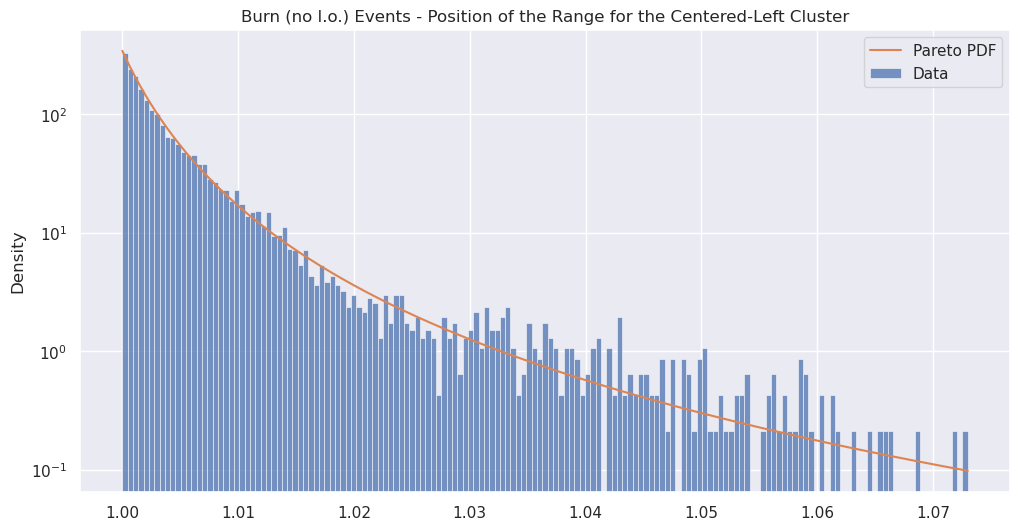

In [25]:
# Plot of the fit
my_p_pars = pareto.fit(x_temp)
print(my_p_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x_temp, ax=ax, stat='density', label='Data')

ax.set_yscale('log')
pdf = pareto.pdf(np.linspace(np.min(x_temp), np.max(x_temp), 10000), *my_p_pars)
sns.lineplot(x=np.linspace(np.min(x_temp), np.max(x_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Pareto PDF')

plt.title("Burn (no l.o.) Events - Position of the Range for the Centered-Left Cluster")
ax.legend()
plt.show()

In [26]:
x_temp = x_right

# Comparison of the log-likelihood
max_ll, best_dist = -np.inf, None
for dist, name in zip([halfcauchy, fatiguelife, genpareto, kappa3, pareto, qPowerLaw],
                      ['Half-Cauchy', 'Fatigue Life', 'Generalized Pareto', 'Kappa 3', 'Pareto', 'qPowerLaw']):
    try:
        if name != 'qPowerLaw':
            pars = dist.fit(x_temp)
            print(f"{name} - Parameters: {pars}")
            curr_ll = general_ll(x_temp, dist.pdf, pars)
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        else:
            pars = dist.general_fit(x_temp)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(x_temp, dist.pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

Half-Cauchy - Parameters: (0.9999999999978202, 0.000591639682221427)
Half-Cauchy - Log-Likelihood: 39671.3725270604

Fatigue Life - Parameters: (1.8382878505268865, 0.9999766132259464, 0.0006340496972860079)
Fatigue Life - Log-Likelihood: 40054.53727473566

Generalized Pareto - Parameters: (-3.1699331398657002, 0.12478710068815377, 2.8594322575380877)
Generalized Pareto - Log-Likelihood: 10111.217308031522

Kappa 3 - Parameters: (2.1328498918155647, 0.9994867460044417, 0.0014269703766856775)
Kappa 3 - Log-Likelihood: 37175.15326295285

Pareto - Parameters: (1.3796604818693452, 0.999055489637962, 0.0009445103620380201)
Pareto - Log-Likelihood: 39934.193108909254

qPowerLaw - Parameters: [0.22698281998758343, 1.9492091178190591, 0.9999870529569752, -0.7076409229142747, 1.707640132670392]
qPowerLaw - Log-Likelihood: 12531.324281505997

The best distribution is: Fatigue Life, with a Log-Likelihood of 40054.53727473566


In [31]:
# Comparison test

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = fatiguelife
top_pars = top_dist.fit(x_temp)
for dist, name in zip([pareto, genpareto, kappa3, halfcauchy, qPowerLaw],
                      ['Pareto', 'Generalized Pareto', 'Kappa 3', 'Half-Cauchy', 'qPowerLaw']):
    if name != 'qPowerLaw':
        temp_par = dist.fit(x_temp)
        test_res = boot_test(
            x_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *temp_par), random_seed)
    else:
        temp_par = dist.fit(x_temp)
        test_res = boot_test(
            x_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)
    print(f"{name} - test result: {test_res}")

Pareto - test result: {'statistic': -5.745548981330936, 'p_value': 0.0}
Generalized Pareto - test result: {'statistic': -209.31288047590064, 'p_value': 0.0}
Kappa 3 - test result: {'statistic': -62.66718629000555, 'p_value': 0.0}
Half-Cauchy - test result: {'statistic': -12.60376896694234, 'p_value': 0.0}
qPowerLaw - test result: {'statistic': -207.1704901418054, 'p_value': 0.0}


In [28]:
# Direct test

my_p_pars = halfcauchy.fit(x_temp)
print(kstest(x_temp, 'pareto', args=my_p_pars))

g_test_discrete(x_temp, halfcauchy, my_p_pars)

KstestResult(statistic=0.9791913380329159, pvalue=0.0, statistic_location=1.0176473225181428, statistic_sign=1)

G-test (Likelihood Ratio Test) Results:
G-statistic: -205777.5185220372
p-value: 1.0
Fail to reject the null hypothesis. The data may follow the specified distribution.


(1.8382878505268865, 0.9999766132259464, 0.0006340496972860079)


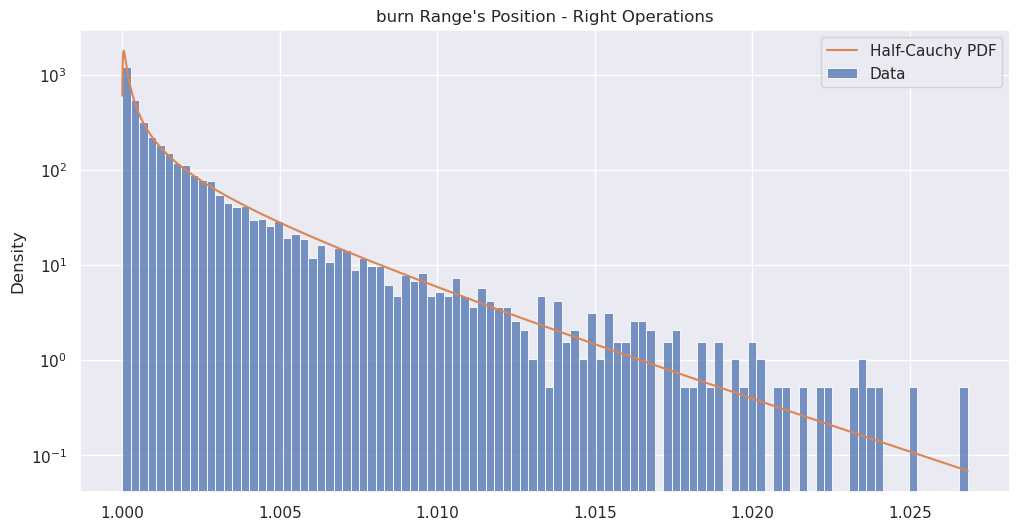

In [32]:
# Plot of the fit
my_p_pars = fatiguelife.fit(x_temp)
print(my_p_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x_temp, ax=ax, stat='density', bins=100, label='Data')

ax.set_yscale('log')
pdf = fatiguelife.pdf(np.linspace(np.min(x_temp), np.max(x_temp), 10000), *my_p_pars)
sns.lineplot(x=np.linspace(np.min(x_temp), np.max(x_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Half-Cauchy PDF')

plt.title("burn Range's Position - Right Operations")
ax.legend()
plt.show()

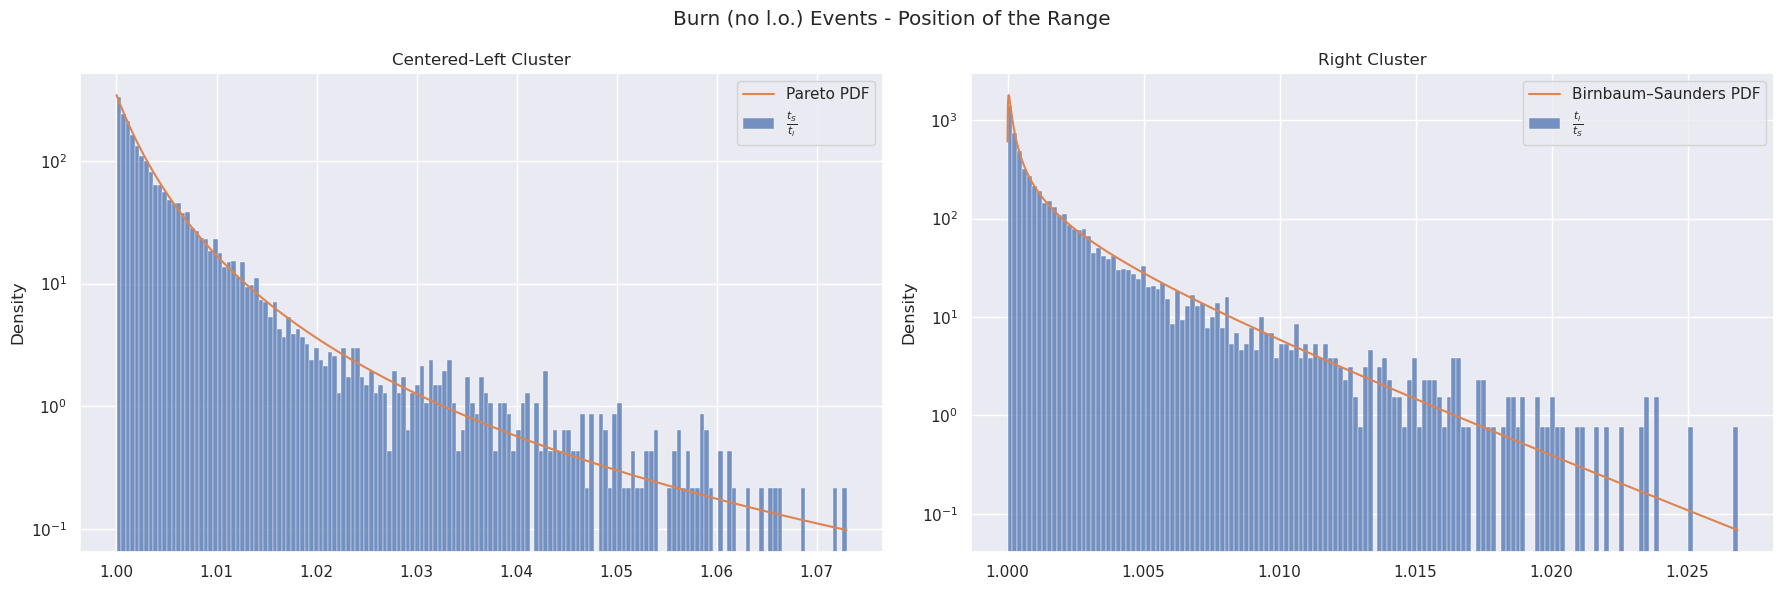

In [33]:
# Plot of the fit
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sub_p = 0
x_temp = 1/x_center_left.copy()
my_p_pars = pareto.fit(x_temp)
pdf = pareto.pdf(np.linspace(np.min(x_temp), np.max(x_temp), 10000), *my_p_pars)

ax[sub_p].set_yscale('log')
sns.histplot(x_temp, ax=ax[sub_p], stat='density', label=r'$\frac{t_S}{t_l}$')
sns.lineplot(x=np.linspace(np.min(x_temp), np.max(x_temp), 10000),
             y=pdf,
            ax=ax[sub_p], color=sns.color_palette()[1], label='Pareto PDF')

ax[sub_p].set_title("Centered-Left Cluster")
ax[sub_p].legend()

sub_p = 1
x_temp = x_right.copy()
my_p_pars = fatiguelife.fit(x_temp)
pdf = fatiguelife.pdf(np.linspace(np.min(x_temp), np.max(x_temp), 10000), *my_p_pars)

ax[sub_p].set_yscale('log')
sns.histplot(x_temp, ax=ax[sub_p], stat='density', label=r'$\frac{t_l}{t_S}$')
sns.lineplot(x=np.linspace(np.min(x_temp), np.max(x_temp), 10000),
             y=pdf,
            ax=ax[sub_p], color=sns.color_palette()[1], label='Birnbaum–Saunders PDF')

ax[sub_p].set_title("Right Cluster")
ax[sub_p].legend()

plt.suptitle("Burn (no l.o.) Events - Position of the Range")
plt.tight_layout()
plt.show()

In [30]:

# Unconditional probability center-left, right
print(r'Unconditional P$\left(\{flag \in center-left\}\right) =$',  np.sum([tf in ('c', 'l') for tf in flag]) / len(flag) )
print(r'Unconditional P$\left(\{flag == right\}\right) =$',  np.sum([tf in ('r') for tf in flag]) / len(flag) )
print()

# Conditional on center-left
print(r'Conditional P$\left(\{flag \in center-left\} | \{flag_{-1} \in center-left\}\right) =$',  np.sum([(tf in ('c', 'l')) & (tf1 in ('c', 'l')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('c', 'l') for tf in flag[:-1]]) )
print(r'Conditional P$\left(\{flag == right\} | \{flag_{-1} \in center-left\}\right) =$',  np.sum([(tf in ('r')) & (tf1 in ('c', 'l')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('c', 'l') for tf in flag[:-1]]) )
print()

# Conditional on right
print(r'Conditional P$\left(\{flag \in center-left\} | \{flag_{-1} \in center-left\}\right) =$',  np.sum([(tf in ('c', 'l')) & (tf1 in ('r')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('r') for tf in flag[:-1]]) )
print(r'Conditional P$\left(\{flag == right\} | \{flag_{-1} \in center-left\}\right) =$',  np.sum([(tf in ('r')) & (tf1 in ('r')) for tf, tf1 in zip(flag[1:], flag[:-1])]) / np.sum([tf in ('r') for tf in flag[:-1]]) )


Unconditional P$\left(\{flag \in center-left\}\right) =$ 0.5854742797759944
Unconditional P$\left(\{flag == right\}\right) =$ 0.4145257202240055

Conditional P$\left(\{flag \in center-left\} | \{flag_{-1} \in center-left\}\right) =$ 0.7173848732866581
Conditional P$\left(\{flag == right\} | \{flag_{-1} \in center-left\}\right) =$ 0.2826151267133419

Conditional P$\left(\{flag \in center-left\} | \{flag_{-1} \in center-left\}\right) =$ 0.39908065190137904
Conditional P$\left(\{flag == right\} | \{flag_{-1} \in center-left\}\right) =$ 0.600919348098621
